<a href="https://colab.research.google.com/github/sakshijadhav1103/defence_p2/blob/main/Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import os
import shutil
import io
from PIL import Image
import zipfile
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
zip_A_path='/content/gdrive/MyDrive/Google_earth/A.zip'
zip_B_path='/content/gdrive/MyDrive/Google_earth/B.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Function to extract images from a zip file
def extract_images_from_zip(zip_path):
    images = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            with zip_ref.open(file_info) as file:
                image = Image.open(io.BytesIO(file.read()))
                images.append(np.array(image))
    return images

In [5]:
# Extract images from the zip folders
images_A = extract_images_from_zip(zip_A_path)
images_B = extract_images_from_zip(zip_B_path)

In [6]:
# Function to create two-phase image pairs
def create_image_pairs(images_A, images_B):
    image_pairs = []
    for img_A, img_B in zip(images_A, images_B):
        image_pairs.append((img_A, img_B))
    return np.array(image_pairs)

In [7]:
# Create two-phase image pairs
image_pairs = create_image_pairs(images_A, images_B)

In [8]:
print("Image pairs shape:", image_pairs.shape)

Image pairs shape: (445, 2, 1024, 1024, 3)


In [9]:
# Function to visualize image pairs
def visualize_image_pairs(image_pairs, num_pairs=5):
    plt.figure(figsize=(15, 5 * num_pairs))
    for i in range(num_pairs):
        for j in range(2):
            plt.subplot(num_pairs, 2, i * 2 + j + 1)
            plt.imshow(image_pairs[i, j])
            plt.axis('off')
            plt.title(f"Period {j} - Pair {i}")
    plt.show()

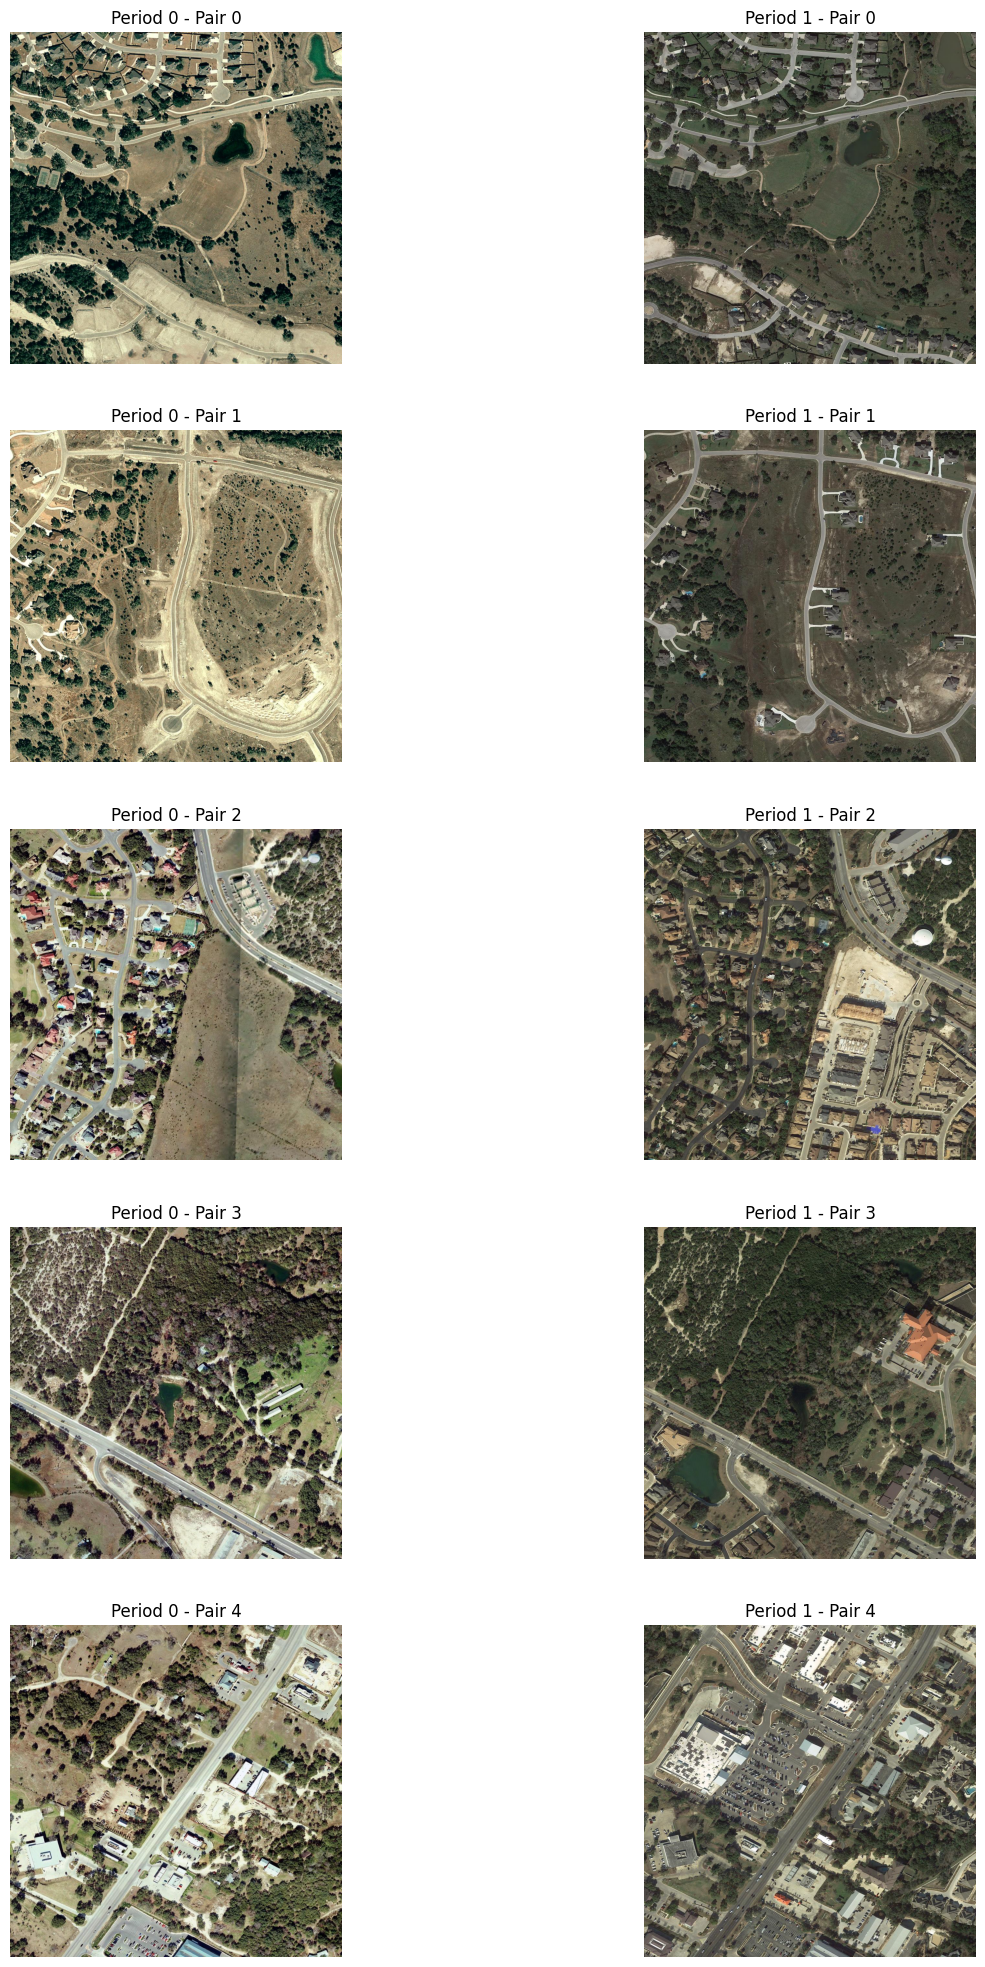

In [10]:
# Visualize the first 5 pairs
visualize_image_pairs(image_pairs, num_pairs=5)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

def unet(input_shape=(None, None, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = Concatenate()([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create the U-Net model
model = unet()

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [12]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load and preprocess input image
input_image = image_pairs[0][0]
input_image = np.array(input_image) / 255.0  # Normalize pixel values to [0, 1]
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Create the U-Net model
model = unet()  # Adjust input shape based on desired image dimensions

# Load pre-trained weights if available
# model.load_weights("unet_weights.h5")

# Make prediction
predicted_mask = model.predict(input_image)

1/1 [==============================] - 28s 28s/step


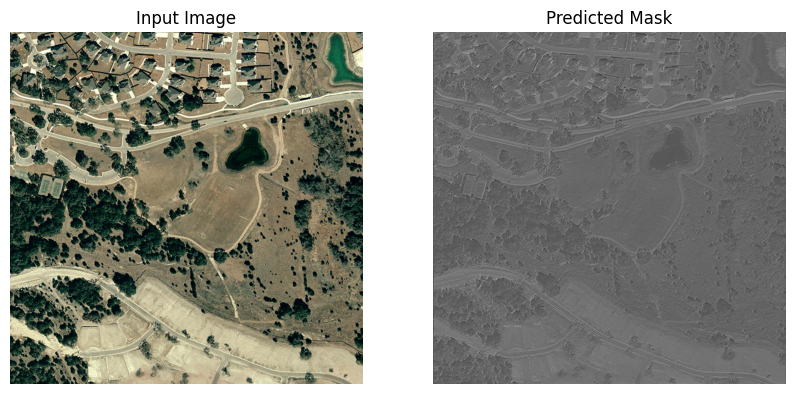

In [13]:
import matplotlib.pyplot as plt

# Assuming `predicted_mask` is the predicted mask obtained from the model

# Reshape the predicted mask if necessary
predicted_mask = predicted_mask.reshape(predicted_mask.shape[1], predicted_mask.shape[2])

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Input Image')
plt.axis('off')

# Display the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()
